# Variability analysis for ctrl vs stim

In [1]:
import scanpy as sc
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from pybedtools import BedTool
import pickle as pkl
%matplotlib inline
import itertools

import statsmodels.formula.api as smf
import statsmodels.api as sm

In [2]:
import sys
sys.path.append('/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.6-py3.8.egg')
sys.path.append('/home/ssm-user/Github/misc-seq/miscseq')
import encode
import memento

In [3]:
data_path = '/data_volume/memento/hbec/'
# fig_path = '/data/home/Github/scrna-parameter-estimation/figures/fig6/'

In [4]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [308]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'small',
         'axes.labelsize': 'medium',
         'axes.titlesize':'medium',
         'figure.titlesize':'medium',
         'xtick.labelsize':'small',
         'ytick.labelsize':'small'}
pylab.rcParams.update(params)

### Read processed adata

In [158]:
adata = sc.read(data_path + 'HBEC_type_I_processed_deep.h5ad')

In [159]:
converter = {'basal/club':'BC', 'basal':'B', 'ciliated':'C', 'goblet':'G', 'ionocyte/tuft':'IT', 'neuroendo':'N'}

In [160]:
adata.obs['ct'] = adata.obs['cell_type'].apply(lambda x: converter[x])

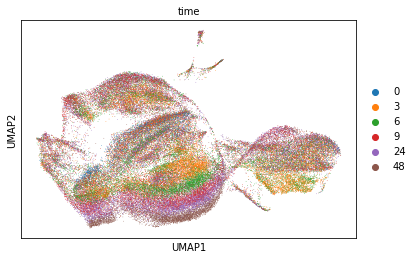

In [163]:
sc.pl.umap(adata, color='time')

### Read 1D HT results

In [6]:
cts = ['C', 'B', 'BC', 'all_ct']
tps = [ '3', '6', '9', '24', '48']
stims = ['alpha', 'beta', 'gamma', 'lambda']

In [7]:
def read_result(ct):
    
    ht_dict = {}
    moments_dict = {}
    
    for stim in stims:
        ht_dict[stim] = {}
        moments_dict[stim] = {}
        for tp in tps: 
            adata_subset = sc.read(data_path + '/binary_test_latest/{}_{}_{}.h5ad'.format(ct, stim, tp))
            ht_dict[stim][tp] = memento.get_1d_ht_result(adata_subset)
            ht_dict[stim][tp]['de_fdr'] = memento.util._fdrcorrect(ht_dict[stim][tp]['de_pval'])
            ht_dict[stim][tp]['dv_fdr'] = memento.util._fdrcorrect(ht_dict[stim][tp]['dv_pval'])
            moments_dict[stim][tp] = memento.get_1d_moments(adata_subset, groupby='time_step')
    return ht_dict,moments_dict

In [18]:
all_moment = {}
all_ht = {}
for ct in cts:
    all_ht[ct], all_moment[ct] = read_result(ct)

/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.6-py3.8.egg/memento/main.py:523: RuntimeWarning: divide by zero encountered in log
/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.6-py3.8.egg/memento/main.py:550: RuntimeWarning: divide by zero encountered in log


In [19]:
# tp = '6'
# ct = 'all_ct'
# for idx, stim in enumerate(stims):
    
#     if idx == 0:
#         df = all_ht[ct][stim][tp][['gene', 'de_coef', 'de_pval', 'de_fdr']].rename(columns=dict(zip(['de_coef', 'de_pval', 'de_fdr'], ['logfc_'+stim, 'pv_'+stim, 'fdr_'+stim])))
#     else:
#         a = all_ht[ct][stim][tp][['gene', 'de_coef', 'de_pval', 'de_fdr']].rename(columns=dict(zip(['de_coef', 'de_pval', 'de_fdr'], ['logfc_'+stim, 'pv_'+stim, 'fdr_'+stim])))
#         df = df.merge(a, on='gene', how='outer')

### Get ISG classes

In [64]:
isg_classes = pd.read_csv('../isg_classes.csv')

In [88]:
t1_isg = isg_classes.query('overall_type =="type1"').gene.tolist()
t2_isg = isg_classes.query('overall_type =="type2"').gene.tolist()
shared_isg = isg_classes.query('overall_type == "shared"').gene.tolist()

### Scatter plots

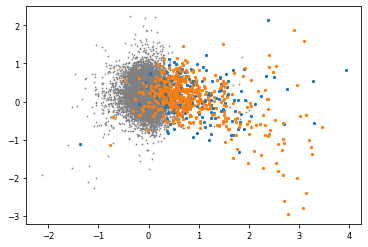

In [130]:
tp = 3
stim = 'beta'
plt.scatter(
    all_ht['all_ct'][stim][tp]['de_coef'],
    all_ht['all_ct'][stim][tp]['dv_coef'],
    s=0.5, color='gray'
)

plt.scatter(
    all_ht['all_ct'][stim][tp].query('gene in @shared_isg')['de_coef'],
    all_ht['all_ct'][stim][tp].query('gene in @shared_isg')['dv_coef'],
    s=5
)

plt.scatter(
    all_ht['all_ct'][stim][tp].query('gene in @t1_isg')['de_coef'],
    all_ht['all_ct'][stim][tp].query('gene in @t1_isg')['dv_coef'],
    s=5
)

In [256]:
ct = 'BC'
dv_up = all_ht[ct]['beta'][3].query('de_fdr < 0.05 & de_coef > 1 & dv_coef > 0.5 & dv_fdr < 0.1').sort_values('dv_coef', ascending=False)
dv_down = all_ht[ct]['beta'][3].query('de_fdr < 0.05 & de_coef > 1 & dv_coef < -1 & dv_fdr < 0.1').sort_values('dv_coef', ascending=False)

df = pd.concat([dv_up, dv_down])

In [257]:
candidates = df[['gene', 'dv_coef']]

In [259]:
# ct = 'C'
a = pd.DataFrame()
a['expr'] = adata.raw[adata.obs.ct == ct, 'CXCL10'].X.todense().A1
a['stim'] = adata[adata.obs.ct == ct].obs['stim'].values
a['time'] = adata[adata.obs.ct == ct].obs['time'].values.astype(str)
a['gene'] = 'CXCL10'

b = pd.DataFrame()
b['expr'] = adata.raw[adata.obs.ct == ct, 'IFI44L'].X.todense().A1
b['stim'] = adata[adata.obs.ct == ct].obs['stim'].values
b['time'] = adata[adata.obs.ct == ct].obs['time'].values.astype(str)
b['gene'] = 'IFI44L'

c = pd.concat([a,b])

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/seaborn/categorical.py:2802: UserWarning: The `split` parameter has been renamed to `dodge`.
  warnings.warn(msg, UserWarning)


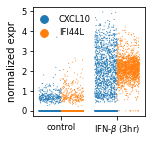

In [325]:
plt.figure(figsize=(2,2))
# sns.violinplot(x='time', y='expr', hue='gene', data=c.query('stim in ["beta", "control"] & time in ["0", "3"]'))
sns.stripplot(x='time', y='expr', hue='gene', data=c.query('stim in ["beta", "control"] & time in ["0", "3"]').sort_values('time'), s=1, split=True, jitter=0.4)
plt.legend(frameon=False, bbox_to_anchor=(-.05,1), loc='upper left');
plt.ylabel('normalized expr');
plt.xlabel(None); plt.xticks([0, 1], ['control', r'IFN-$\beta$ (3hr)'])
plt.savefig('variability_example.png', dpi=800)

In [198]:
a

,expr,condition
0,1.634432,alpha
1,0.827604,gamma
2,1.122085,beta
3,2.455761,alpha
4,3.321051,beta
...,...,...
29787,0.497333,lambda
29788,3.714715,beta
29789,0.511092,beta
29790,0.000000,gamma


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

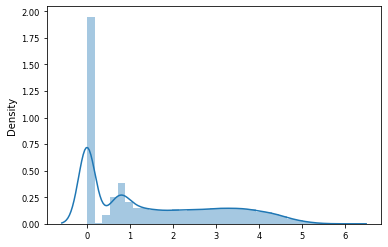

In [192]:
sns.distplot(adata.raw[adata.obs.ct == 'BC', 'CXCL10'].X.todense().A1)

In [187]:
all_moment['BC']['beta'][3][0].merge(candidates, on='gene').sort_values('time_step_1', ascending=False)

,gene,time_step_1,time_step_0,dv_coef
0,ISG15,3.401832,1.282065,-2.059432
23,IFI27,3.261462,1.346843,-1.396250
1,IFI6,3.132540,0.933120,-1.560257
30,BST2,1.919949,0.248789,-1.183137
17,IFIT1,1.760246,-0.604885,-1.382614
33,MX1,1.753097,-0.104960,-1.880321
24,ISG20,1.712788,0.150681,-1.336041
18,IFITM1,1.672930,-0.519539,-1.034723
11,SAMD9,1.614949,0.120930,-1.210025
28,LGALS3BP,1.589011,0.541218,1.045295


### Individual plots

### quick gseapy

In [105]:
import gseapy as gp

In [151]:
df = all_ht['all_ct']['beta'][3].query('de_fdr < 0.05 & de_coef > 1').sort_values('dv_coef', ascending=False)[['gene', 'dv_coef']]

In [152]:
pre_res = gp.prerank(rnk=df, gene_sets='GO_Molecular_Function_2018',
                     processes=4,
                     permutation_num=500, # reduce number to speed up testing
                     outdir=None, seed=6)

In [153]:
pre_res.res2d#.query('es > 0')

,es,nes,pval,fdr,geneset_size,matched_size,genes,ledge_genes
Term,,,,,,,,
RNA binding (GO:0003723),-0.614128,-1.746576,0.000000,0.002621,1388,32,H1F0;TDRD7;ZC3HAV1;IFI16;PATL2;APOBEC3G;TLR3;A...,HLA-A;HELZ2;APOBEC3A;HERC5;IFIH1;EIF2AK2;DHX58...
DNA binding (GO:0003677),-0.264531,-0.686286,0.849057,0.876802,894,19,HIST1H2BH;AIM2;BRIP1;HIST1H2BC;HIST2H2BE;IFI16...,HIST1H2BJ;NUPR1;ZBP1;IRF1;STAT1;DDX60


In [132]:
df[df['gene'].str.startswith("HLA")]

,gene,dv_coef
3585,HLA-G,2.149475
3595,HLA-E,-0.259806
3586,HLA-A,-0.504704
3612,HLA-C,-0.516038
3583,HLA-F,-0.606011
3613,HLA-B,-0.873580
